# Welcome to Passion!
Passion is a model that can detection anomaly using different methods (Both supervised and unsupervised) <br>

1. The goal for this project is to study the difference between different anomnaly detection model, and to   <br>
 find the state of art method for detecting anomaly in real world data<br>
2. Evaluate the results based on this :real server data+ https://www.kaggle.com/sohier/30-years-of-european-wind-generation + https://github.com/numenta/NAB <br>
3. Also use real data generated from server.
4. The model has the following fuctions: <br>
    a. Visualize the input data. Help the user to find critical features within the inputs. <br>
    b. Give user options to choose different models that are suitable for different circumstances. <br>
    c. Evaluate the performance based on the rules in this link https://github.com/numenta/NAB <br>
    d. Save model. Easy to be appplied to other dataset. <br>

5. This is the very beginning of the process. Still need to do a lot of works!




# What's new in version 4
1. Add LSTM based model (Also include HMM features)
2. Add more real server data
3. Add Transformer with log sparse attention mechanism.
4. Add dataset from 30 years of EU wind generation: https://www.kaggle.com/sohier/30-years-of-european-wind-generation
5. Better plots

In [1]:
# import packages 


from matplotlib.pylab import rc
import torch
from scipy.stats import chisquare
from scipy.stats import pearsonr 
import pickle
import pandas as pd
import datetime
import matplotlib
import tensorflow as tf
import sklearn
import math
import matplotlib.pyplot as plt
import xgboost
from xgboost import XGBClassifier
from xgboost import plot_importance
import numpy as np
from sklearn.model_selection import train_test_split 
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder 
import copy
import scipy
import datetime
import time
import os
from sklearn.model_selection import KFold 
from sklearn.metrics import roc_curve 
from sklearn.metrics import roc_auc_score
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
import gc

plot_path = "plots/"


In [2]:

# Real server data

root_path = "Data/Ant_202007/"


cif = pd.read_json(root_path+'cif.json', orient='index')
paycore = pd.read_json(root_path+'paycore.json', orient='index')
paydecision = pd.read_json(root_path+'paydecision.json', orient='index')
paydecision2 = pd.read_json(root_path+'paydecision2.json', orient='index')
paydecision3 = pd.read_json(root_path+'paydecision3.json', orient='index')

df = pd.DataFrame()
df["time_stamp"] = cif.index
df["cif"] = cif[0].values
df["paycore"] = paycore[0].values
df["paydecision"] = paydecision[0].values
df["paydecision2"] = paydecision2[0].values
df["paydecision3"] = paydecision3[0].values

# Optional
if False:
    df.to_csv(root_path+"fusion.csv")

    
# convert time stamp
df['time_stamp'] = pd.to_datetime(df['time_stamp'])
names_array = np.array(df.keys()[1:],dtype="str")
os.listdir(root_path)




['cif.json',
 'fusion.csv',
 'paycore.json',
 'paydecision.json',
 'paydecision2.json',
 'paydecision3.json']

# LSTM based model

In [4]:
# Repreat this for all:


df["minutes"]=df["time_stamp"].dt.hour*1440+df["time_stamp"].dt.hour*60+df["time_stamp"].dt.minute
# hyper-parameters:
# delta_t in minute,try a day first,output 5 dimensions
delta_t = 1440
n_epoch=10
n_cell = 50


checkpoint_path = "LSTM/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

y_test_all = {}
y_predict_all = {}

def LSTM_each(ni):
    index_name=ni
    print("Doing %d of %d"%(ni,len(names_array)))
    min_max_scaler = preprocessing.StandardScaler()

    # min-max scaler
    np_scaled = min_max_scaler.fit_transform(df[names_array])

    df_scaled = pd.DataFrame(np_scaled,columns=names_array)


    X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,5),dtype=float)
    y = df_scaled[names_array[index_name]][delta_t:]
    
    for i in range(len(y)):
        if i%10000==0:
            print("Prepare data %.2f percent"%(100*i/len(y)))
        X[i,:,:] = df_scaled[i:i+delta_t][names_array].values

    # split train test:
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)
        
    # design network: A toy LSTM model with 50 units
    model = tf.keras.Sequential([
      tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
      tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mae', optimizer='adam')
    callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

    history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
    y_pre = model.predict(X_test)
    
    y_test_all[index_name] = np.array(y_test)
    y_predict_all[index_name] = np.array(y_pre[:,0])
    




for ni in range(len(names_array)):
    LSTM_each(ni=ni)
    

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for ni in range(len(names_array)):
    plt.subplot(len(names_array),1,ni+1)
    print("Doing %d of %d"%(ni,len(names_array)))
    y_test = y_test_all[ni]
    y_pre = y_predict_all[ni]
    timeline = np.arange(0,len(y_test),1)
    
    plt.plot(timeline/60,y_test,"k",label="data",alpha=1,linewidth=1)
    plt.plot(timeline/60,y_pre,"r",label="Predicted",alpha=1,linewidth=1)

    plt.xlabel("Time in hours")
    plt.ylabel("Normalized %s"%names_array[ni])

    plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,40)
save_path = plot_path + "LSTM_results_all" + ".png"

fig.savefig(save_path, dpi=150)

plt.close()



font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for ni in range(len(names_array)):
    plt.subplot(len(names_array),1,ni+1)
    print("Doing %d of %d"%(ni,len(names_array)))
    y_test = y_test_all[ni]
    y_pre = y_predict_all[ni]
    timeline = np.arange(0,len(y_test),1)
    
    plt.plot(timeline/60,y_test-y_pre,"kx",label="Difference between data and prediction",alpha=1,linewidth=1)

    plt.xlabel("Time in hours")
    plt.ylabel("Difference %s"%names_array[ni])

    plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,40)
save_path = plot_path + "LSTM_results_all_diff" + ".png"

fig.savefig(save_path, dpi=150)

plt.close()




anomaly_ratio = 0.01




font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for ni in range(len(names_array)):
    plt.subplot(len(names_array),1,ni+1)
    print("Doing %d of %d"%(ni,len(names_array)))
    
    y_test = y_test_all[ni]
    y_pre = y_predict_all[ni]
    diff = y_test-y_pre
    
    mask = abs(diff)>np.nanpercentile(abs(diff),100-100*anomaly_ratio)
    timeline = np.arange(0,len(y_test),1)
    
    plt.plot(timeline/60,y_test,"b",alpha=1,linewidth=1)
    plt.plot(timeline[mask]/60,y_test[mask],"ro",label="Anomaly",alpha=1,linewidth=1)

    plt.xlabel("Time in hours")
    plt.ylabel("Normalized %s"%names_array[ni])

    plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(16,40)
save_path = plot_path + "LSTM_results_anomaly_all" + ".png"

fig.savefig(save_path, dpi=150)

plt.close()




 

Doing 0 of 5
Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent
Epoch 1/10
441/441 [==============================] - ETA: 0s - loss: 0.0662
Epoch 00001: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 107ms/step - loss: 0.0662 - val_loss: 0.0348
Epoch 2/10
441/441 [==============================] - ETA: 0s - loss: 0.0296
Epoch 00002: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 106ms/step - loss: 0.0296 - val_loss: 0.0295
Epoch 3/10
441/441 [==============================] - ETA: 0s - loss: 0.0248
Epoch 00003: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 106ms/step - loss: 0.0248 - val_loss: 0.0223
Epoch 4/10
441/441 [==============================] - ETA: 0s - loss: 0.0226
Epoch 00004: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 107ms/step - loss: 0.0226 - val_loss: 0.0210
Epoch 5/1

441/441 [==============================] - ETA: 0s - loss: 0.0156
Epoch 00007: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 104ms/step - loss: 0.0156 - val_loss: 0.0157
Epoch 8/10
441/441 [==============================] - ETA: 0s - loss: 0.0151
Epoch 00008: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 107ms/step - loss: 0.0151 - val_loss: 0.0160
Epoch 9/10
441/441 [==============================] - ETA: 0s - loss: 0.0147
Epoch 00009: saving model to LSTM/cp.ckpt
441/441 [==============================] - 47s 106ms/step - loss: 0.0147 - val_loss: 0.0145
Epoch 10/10
441/441 [==============================] - ETA: 0s - loss: 0.0142
Epoch 00010: saving model to LSTM/cp.ckpt
441/441 [==============================] - 46s 103ms/step - loss: 0.0142 - val_loss: 0.0149
Doing 4 of 5
Prepare data 0.00 percent
Prepare data 24.80 percent
Prepare data 49.60 percent
Prepare data 74.40 percent
Prepare data 99.20 percent
Epoch 1/10
441/441 

# Transformer
Use original + log sparse transformer in predicting Fraud <br>
Finally it comes to the Transformer :)!

In [ ]:
# Apply to both NLP and Time series:


In [2]:
import datetime
# read EU wind data
data_path_eu = "Data/Europe_wind/"
# TS is based on smaller regime, but EMHIRESPV is for countries
# data is for each hour

TS = pd.read_csv(data_path_eu+ "TS.CF.N2.30yr.csv")

EMHIRESPV_TSh_CF_Country_19862015 = pd.read_csv(data_path_eu+"EMHIRESPV_TSh_CF_Country_19862015.csv")
date_array = [datetime.datetime(1986, 1, 1) + datetime.timedelta(hours=i) for i in range(TS.shape[0])]
TS["time_stamp"] = date_array
EMHIRESPV_TSh_CF_Country_19862015["time_stamp"] = date_array
os.listdir(data_path_eu)

['emhires_dataset_part_i_wind_power_generation_0.pdf',
 'EMHIRESPV_TSh_CF_Country_19862015.csv',
 'TS.CF.N2.30yr.csv']

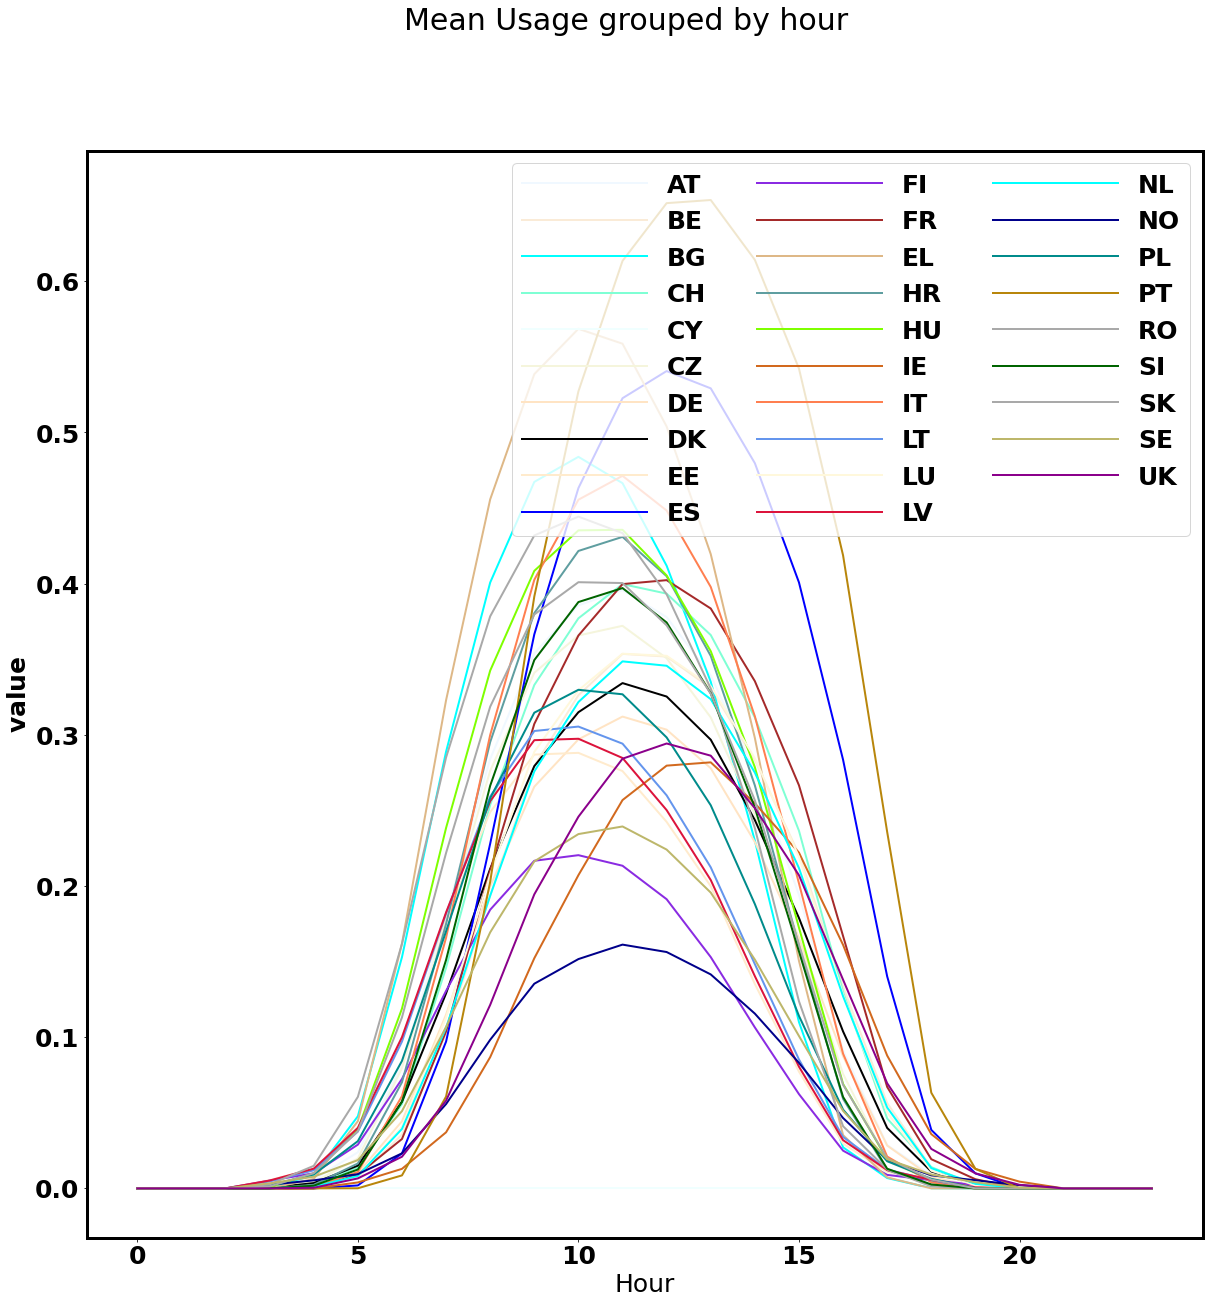

In [95]:
from matplotlib import colors as mcolors
color_array = list(mcolors.CSS4_COLORS.keys())
df = EMHIRESPV_TSh_CF_Country_19862015

names_array = list(df.keys()[:29])


## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


df['hours'] = df['time_stamp'].dt.hour



from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(1,1,1)



for i in range(len(names_array)):
    #print("Doing %d"%i)
    plt.plot(df.groupby('hours').mean().index,df.groupby('hours').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Hour")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Mean Usage grouped by hour")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,20)
plt.legend(fontsize=25,handlelength=5,ncol=3)
save_path = plot_path + "Data_EU_group_by_hour" + ".png"

fig.savefig(save_path, dpi=200)







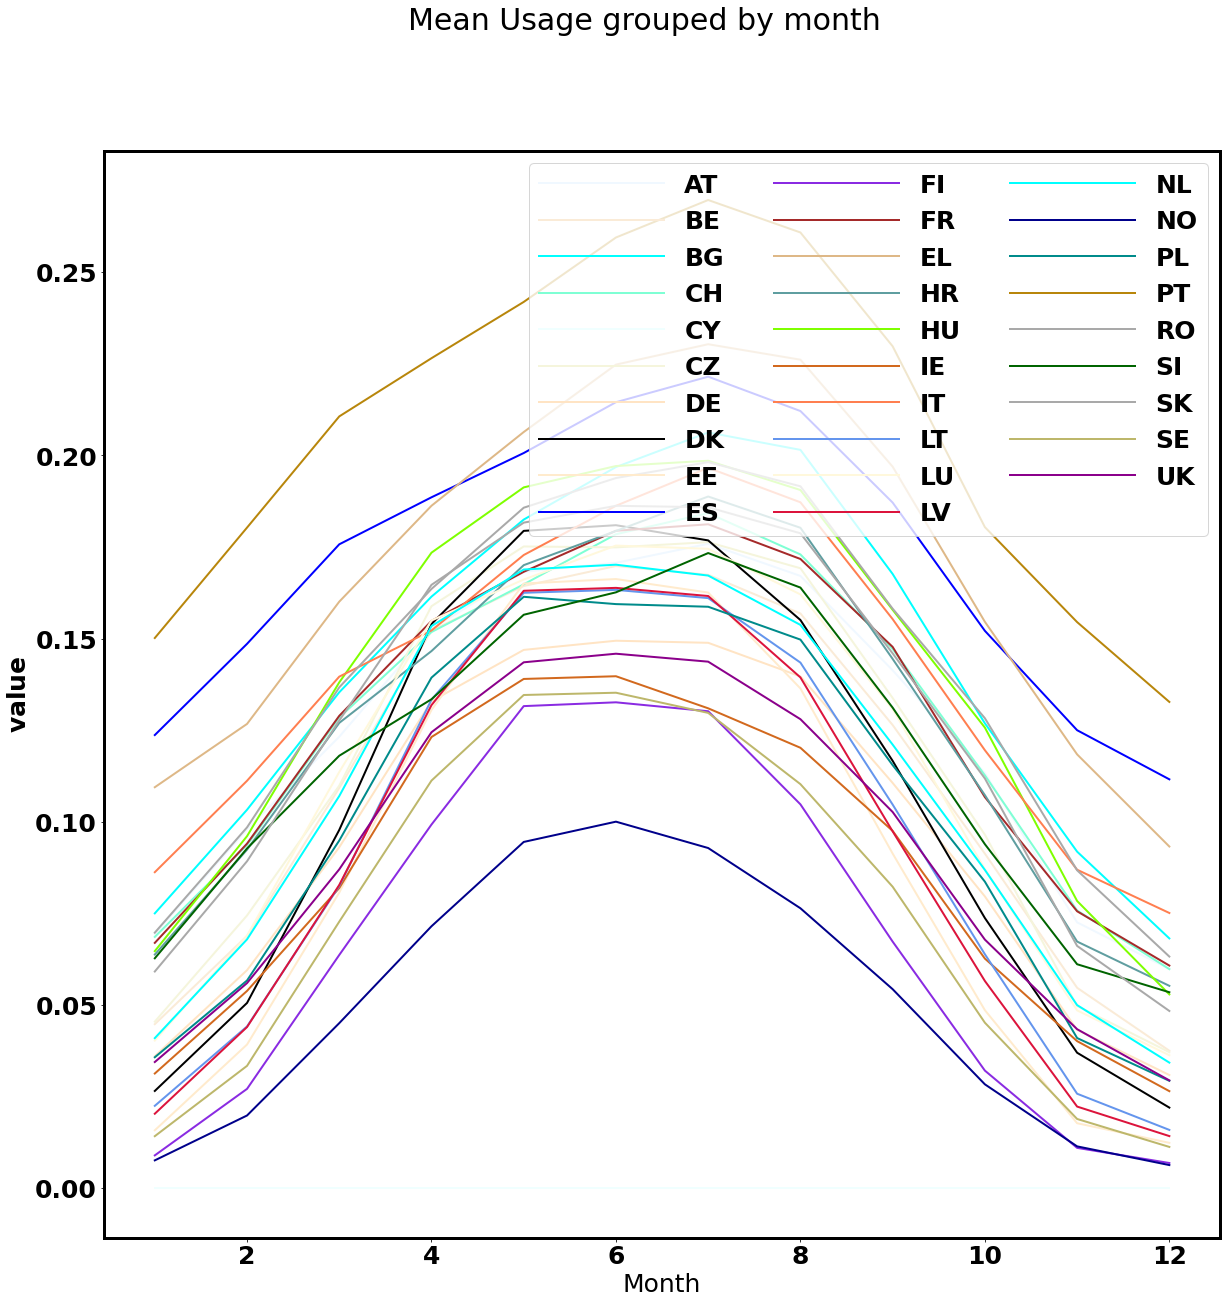

In [103]:
from matplotlib import colors as mcolors
color_array = list(mcolors.CSS4_COLORS.keys())

df = EMHIRESPV_TSh_CF_Country_19862015

names_array = list(df.keys()[:29])


## group by hours
# A rough visualization of the data
import warnings
warnings.filterwarnings('ignore')


df['hours'] = df['time_stamp'].dt.hour
df['month'] = df['time_stamp'].dt.month



from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


plt.subplot(1,1,1)



for i in range(len(names_array)):
    #print("Doing %d"%i)
    plt.plot(df.groupby('month').mean().index,df.groupby('month').mean()[names_array[i]],color_array[i],label=names_array[i],linewidth=2,markersize=5)
    




plt.xlabel("Month")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Mean Usage grouped by month")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(20,20)
plt.legend(fontsize=25,handlelength=5,ncol=3)
save_path = plot_path + "Data_EU_group_by_month" + ".png"

fig.savefig(save_path, dpi=200)








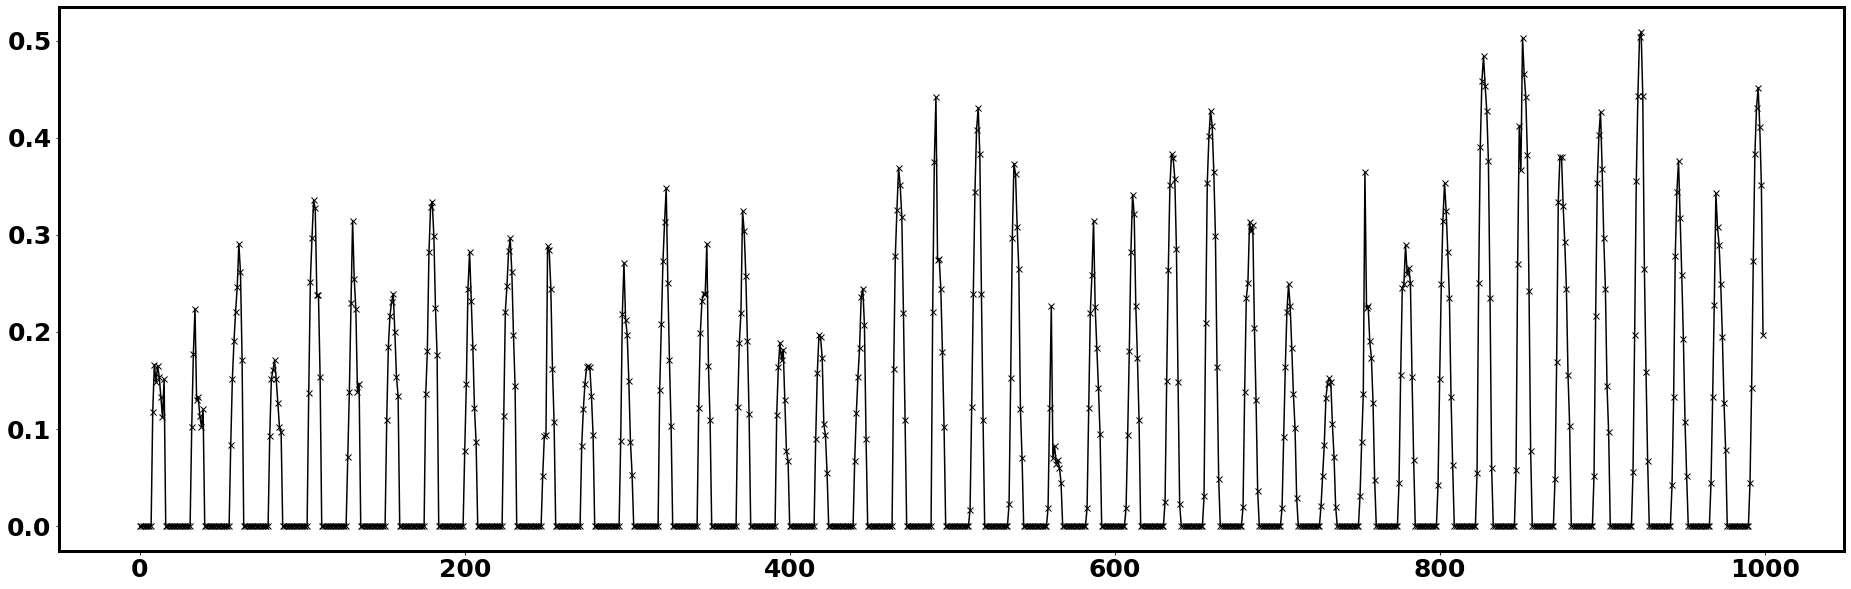

In [109]:
plt.plot(EMHIRESPV_TSh_CF_Country_19862015.iloc[:1000,0],"kx")
plt.plot(EMHIRESPV_TSh_CF_Country_19862015.iloc[:1000,0],"k")
fig = matplotlib.pyplot.gcf()

fig.set_size_inches(32,10)

# There are several periods inside the data. Let's find out

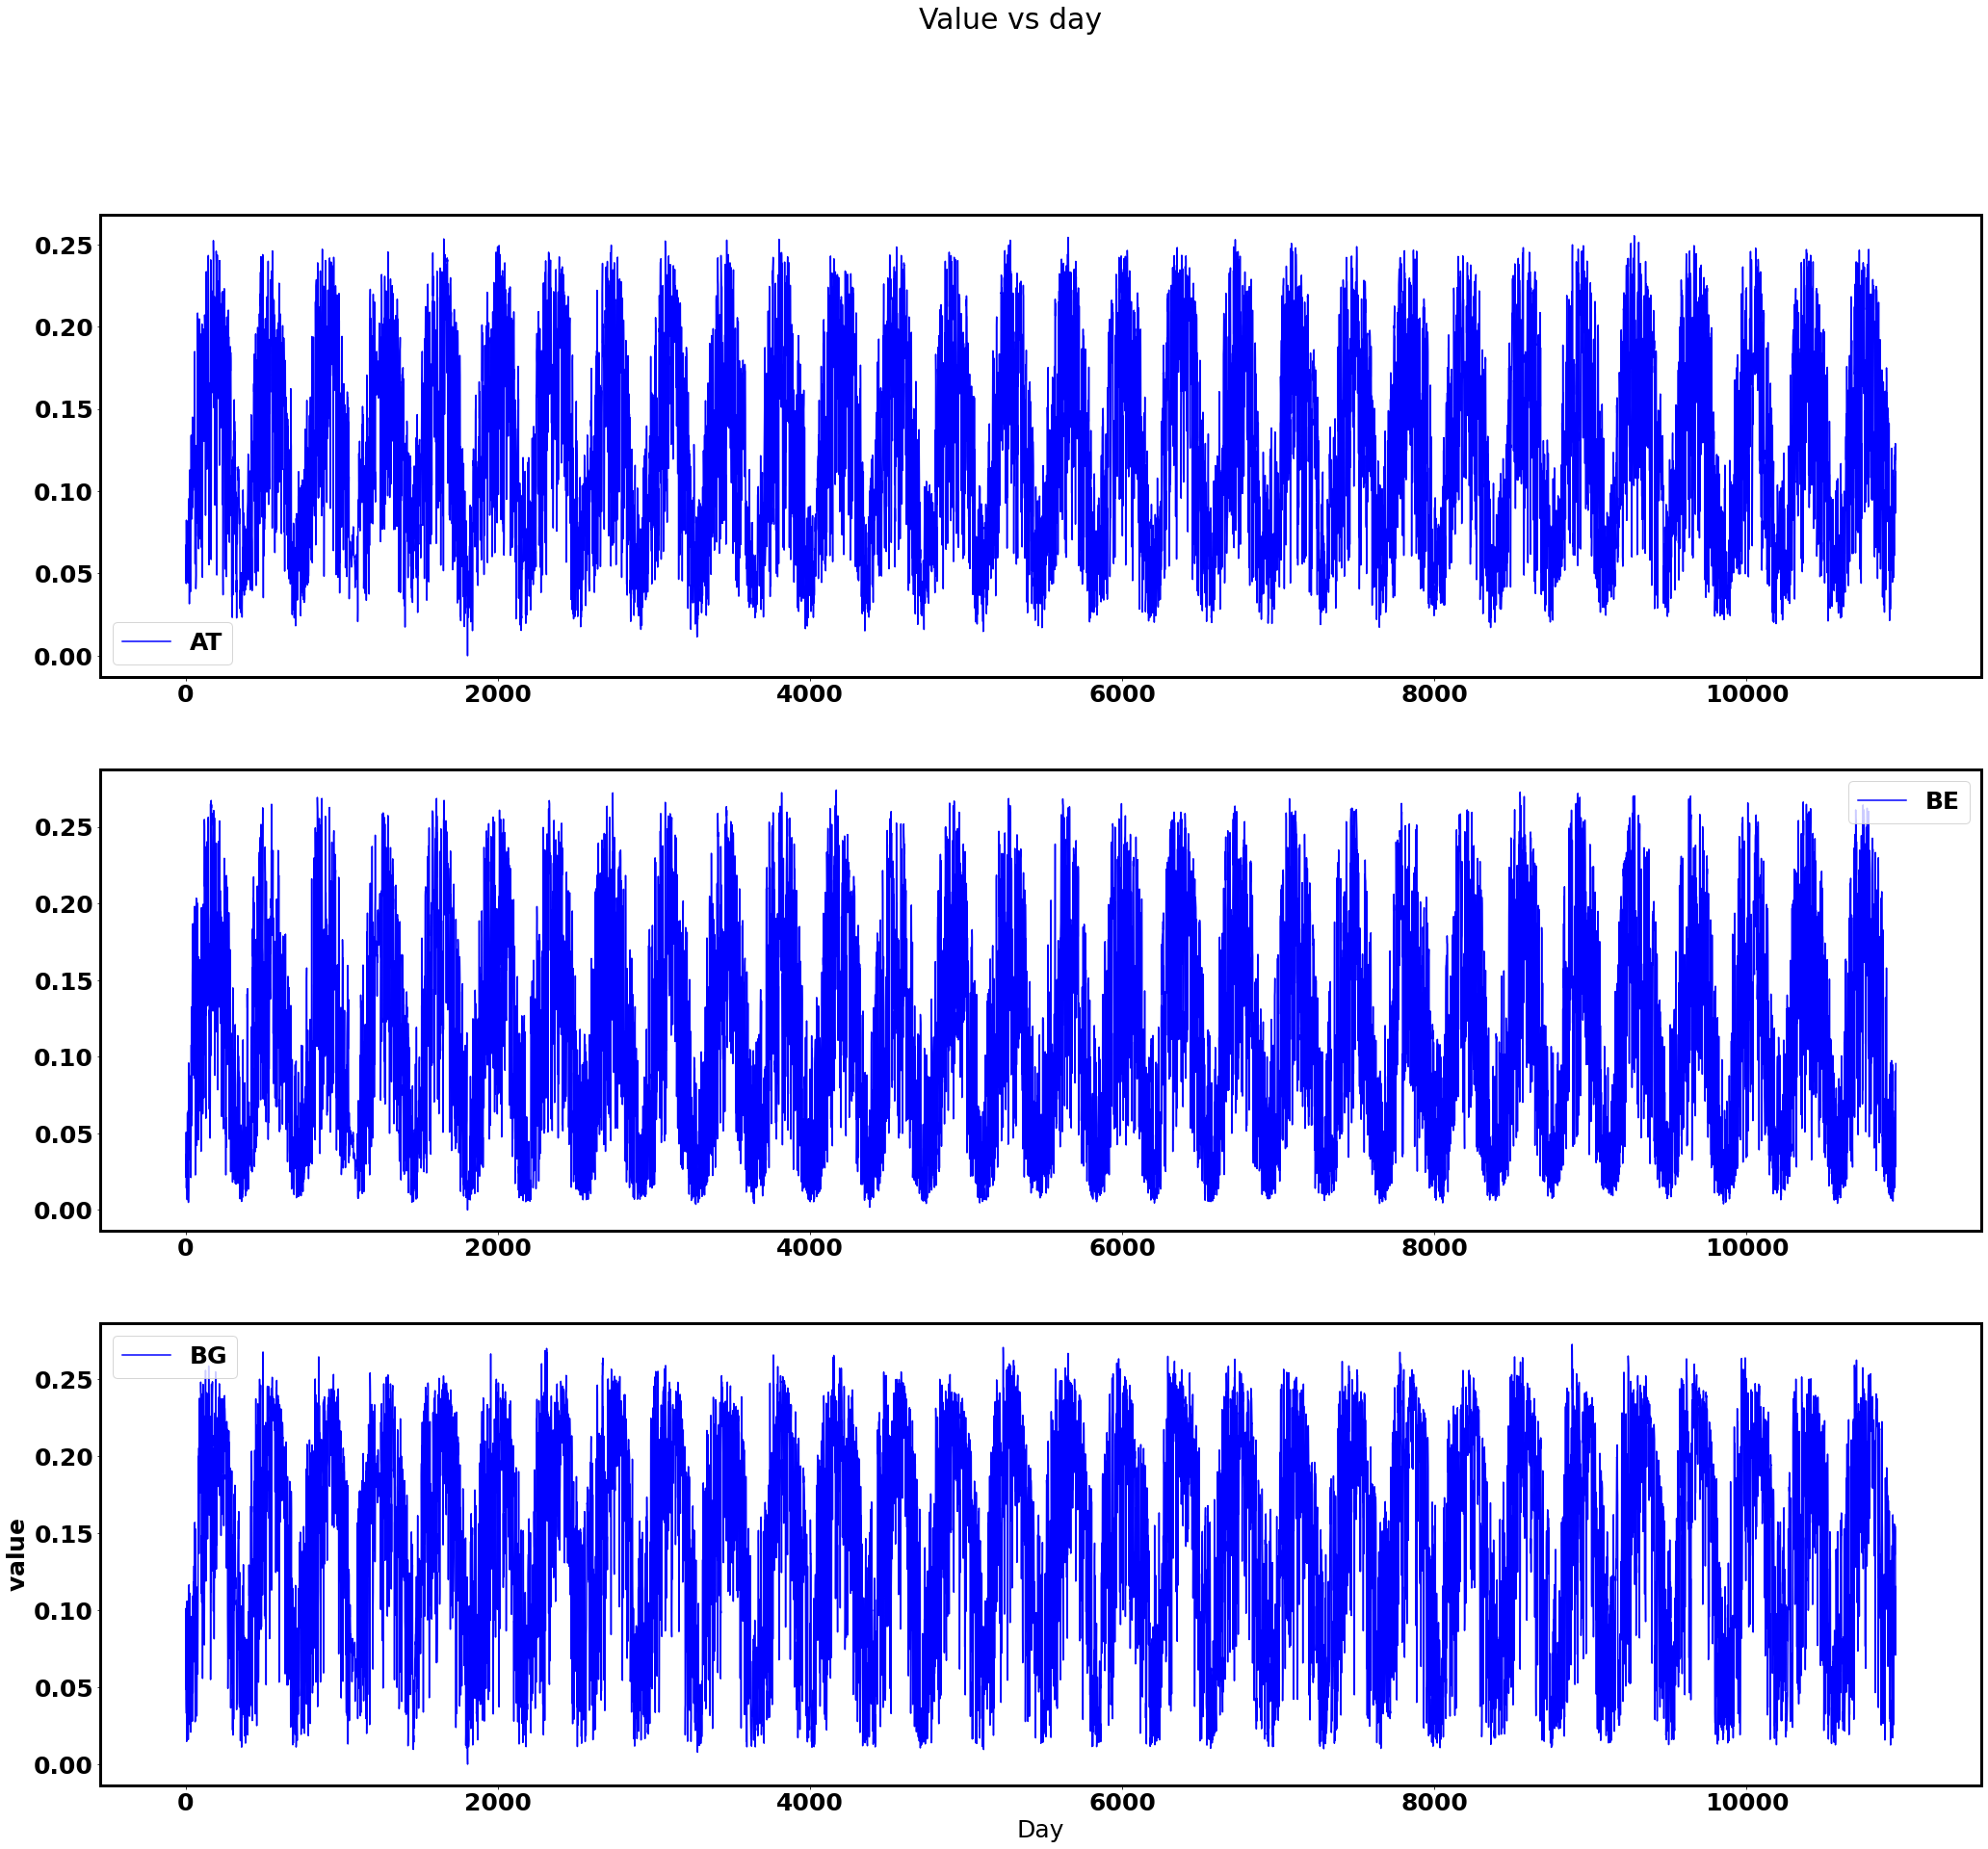

In [118]:
# PLOT VS DAY
df["day_delta"] = np.arange(0,df.shape[0],1)//24





from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for i in range(3):
    plt.subplot(3,1,1+i)

    plt.plot(df.groupby("day_delta").mean()[names_array[i]],"b",label=names_array[i])
    plt.legend()




plt.xlabel("Day")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Value vs day")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(35,30)

save_path = plot_path + "Data_Value_VS_DAY" + ".png"

fig.savefig(save_path, dpi=200)







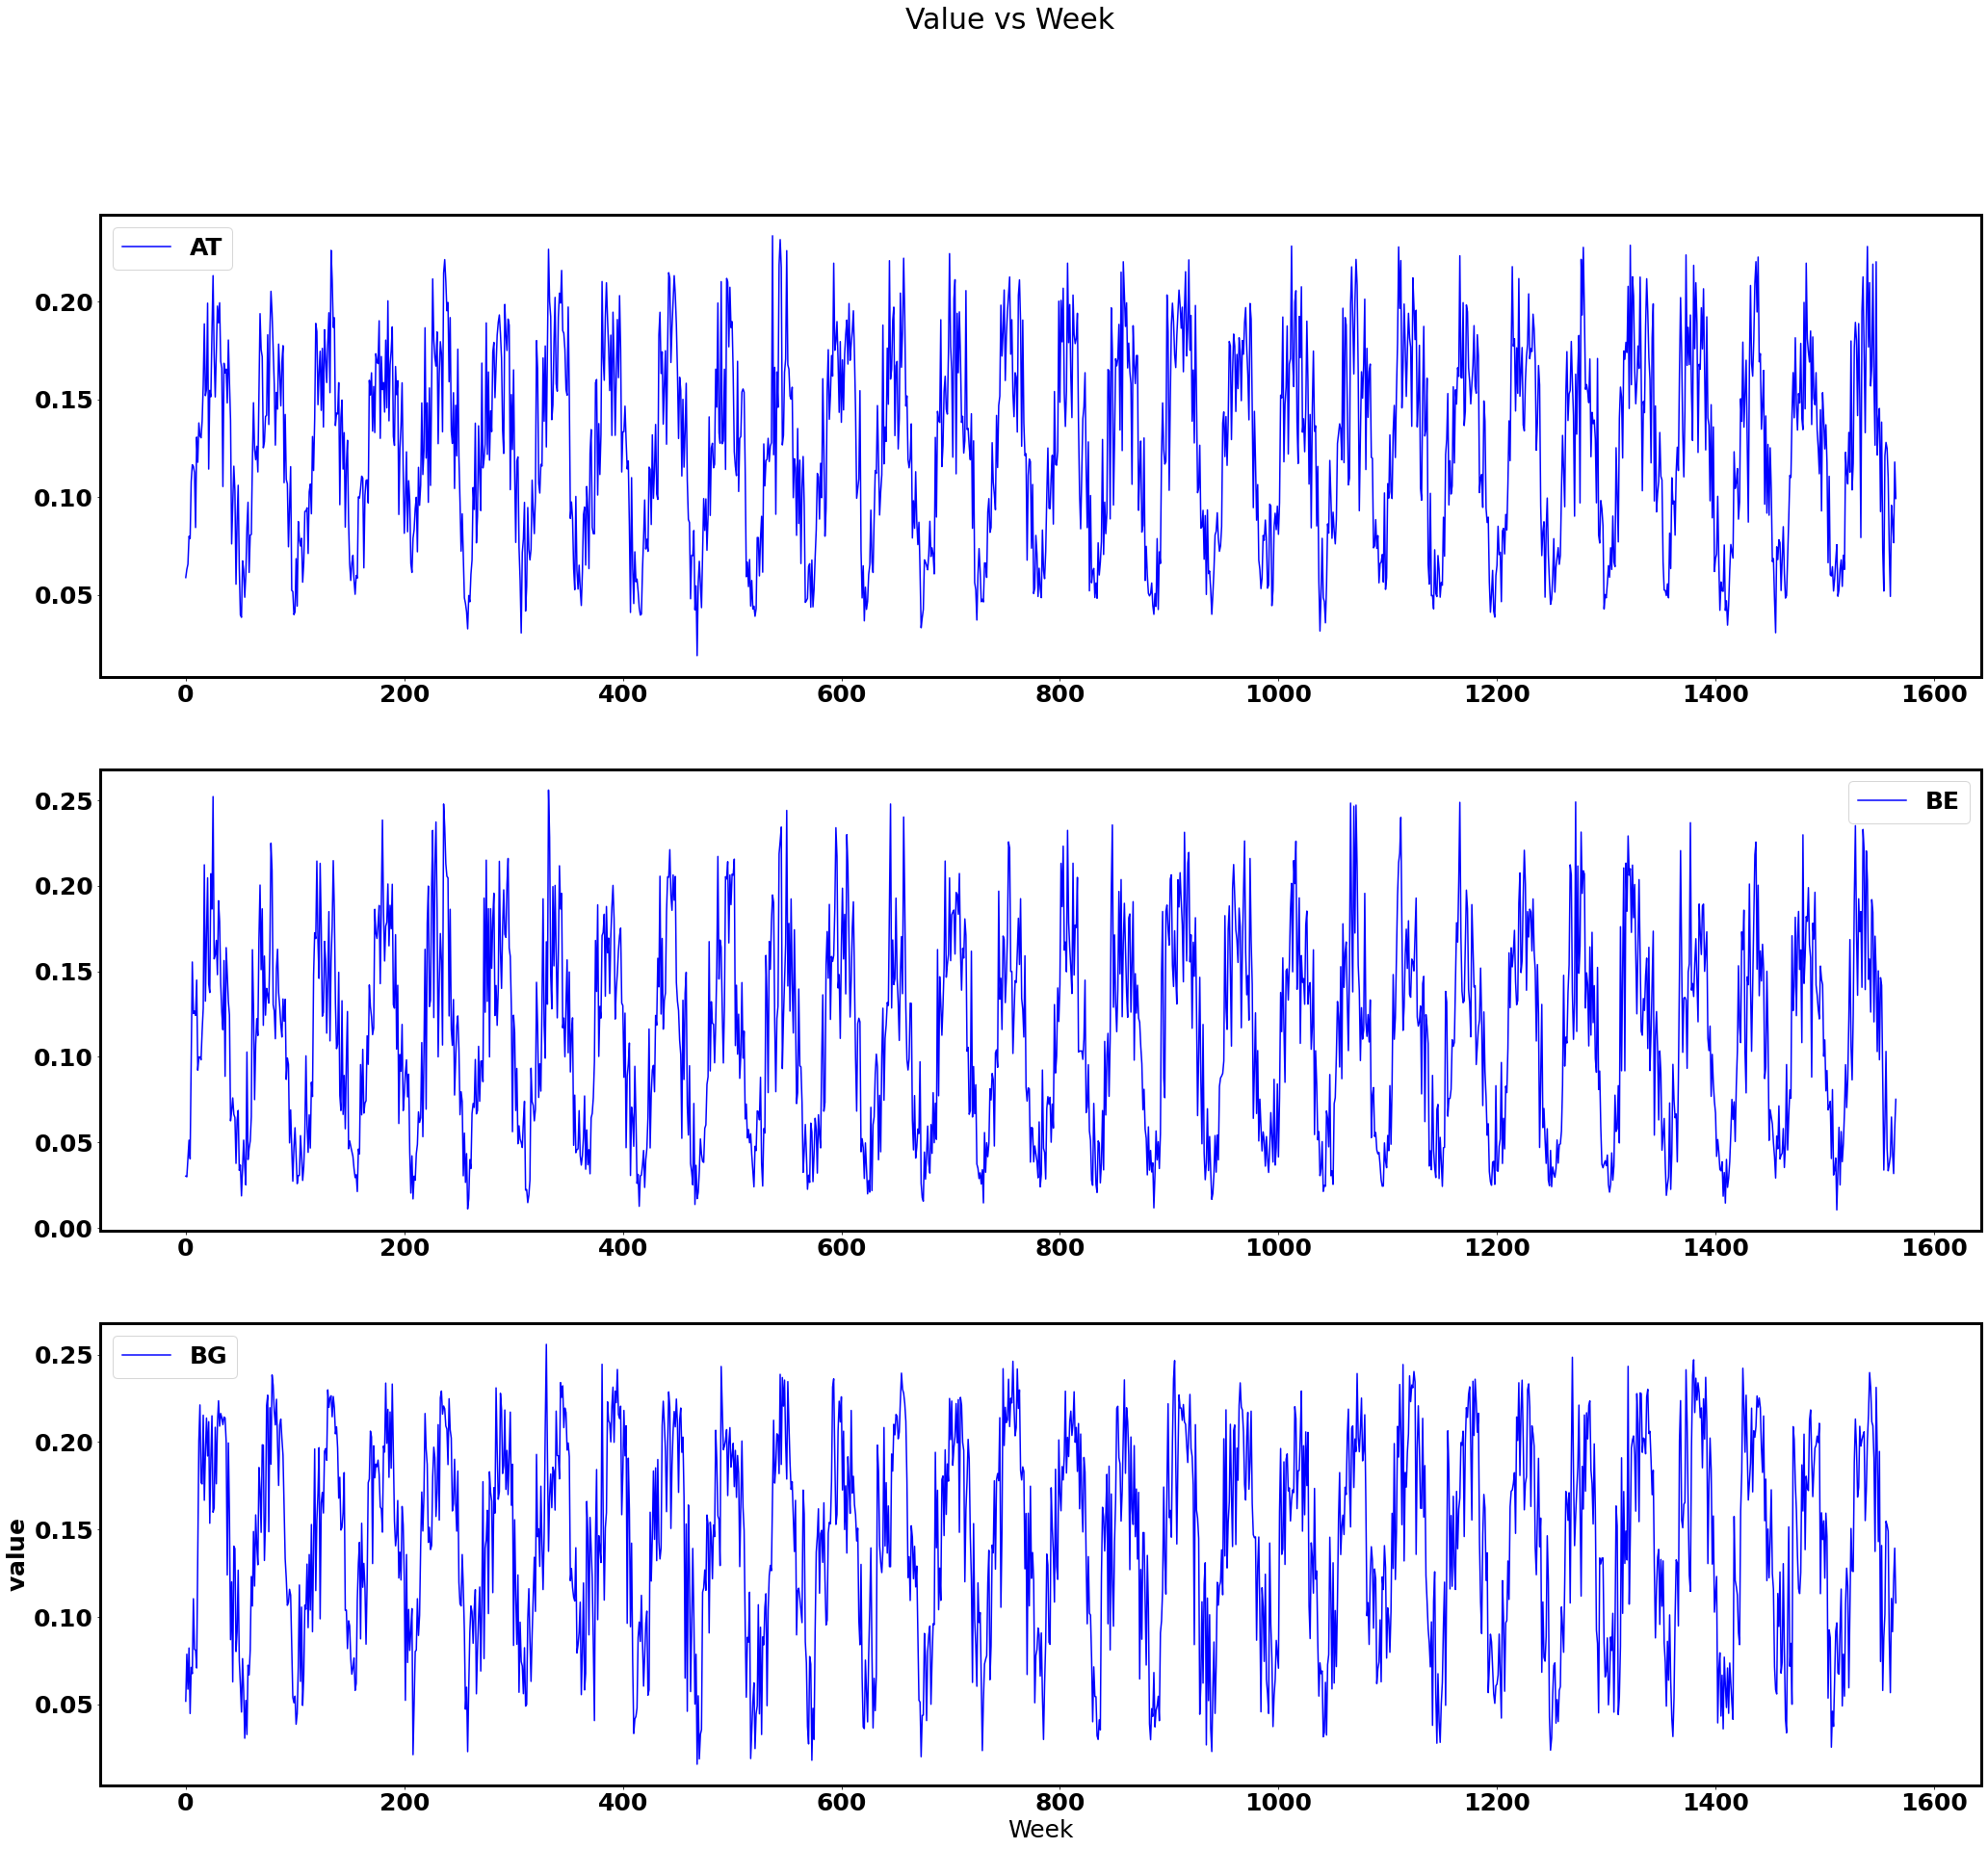

In [119]:
# PLOT VS Month
df["week_delta"] = np.arange(0,df.shape[0],1)//(24*7)





from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for i in range(3):
    plt.subplot(3,1,1+i)

    plt.plot(df.groupby("week_delta").mean()[names_array[i]],"b",label=names_array[i])
    plt.legend()




plt.xlabel("Week")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Value vs Week")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(35,30)

save_path = plot_path + "Data_Value_VS_week" + ".png"

fig.savefig(save_path, dpi=200)








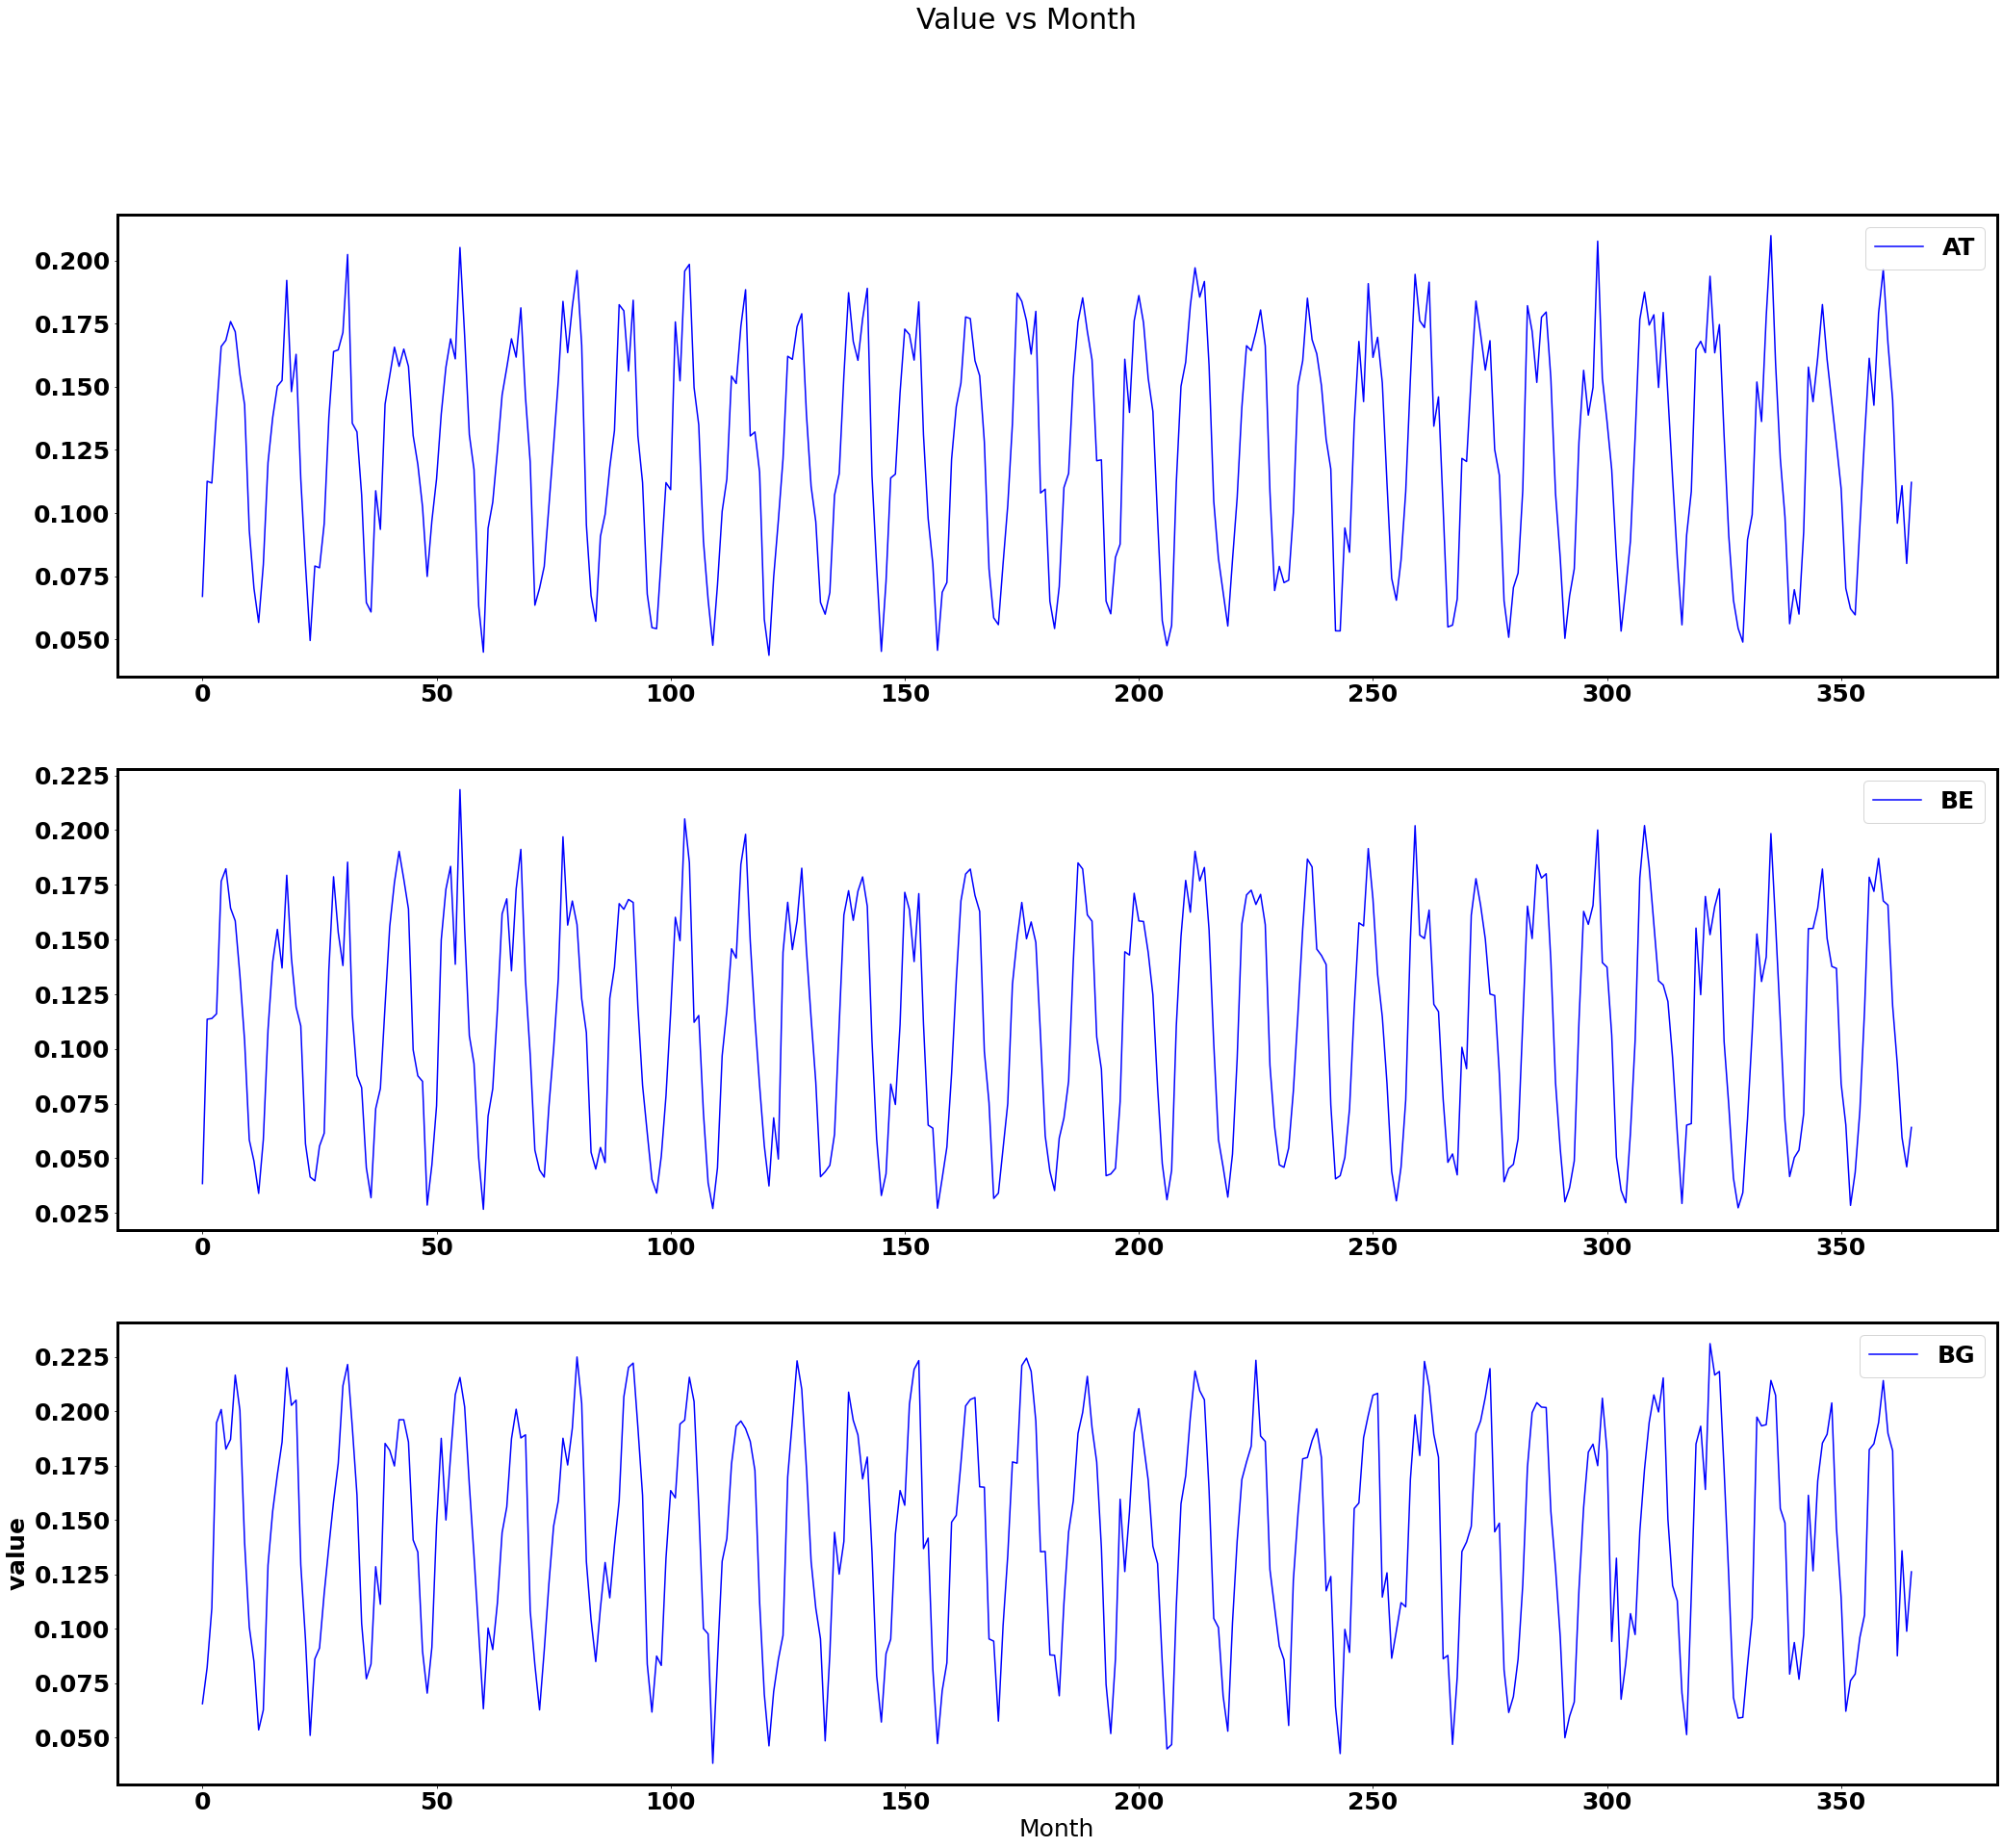

In [120]:
# PLOT VS Month
df["month_delta"] = np.arange(0,df.shape[0],1)//(24*30)


from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for i in range(3):
    plt.subplot(3,1,1+i)

    plt.plot(df.groupby("month_delta").mean()[names_array[i]],"b",label=names_array[i])
    plt.legend()




plt.xlabel("Month")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Value vs Month")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(35,30)

save_path = plot_path + "Data_Value_VS_month" + ".png"

fig.savefig(save_path, dpi=200)









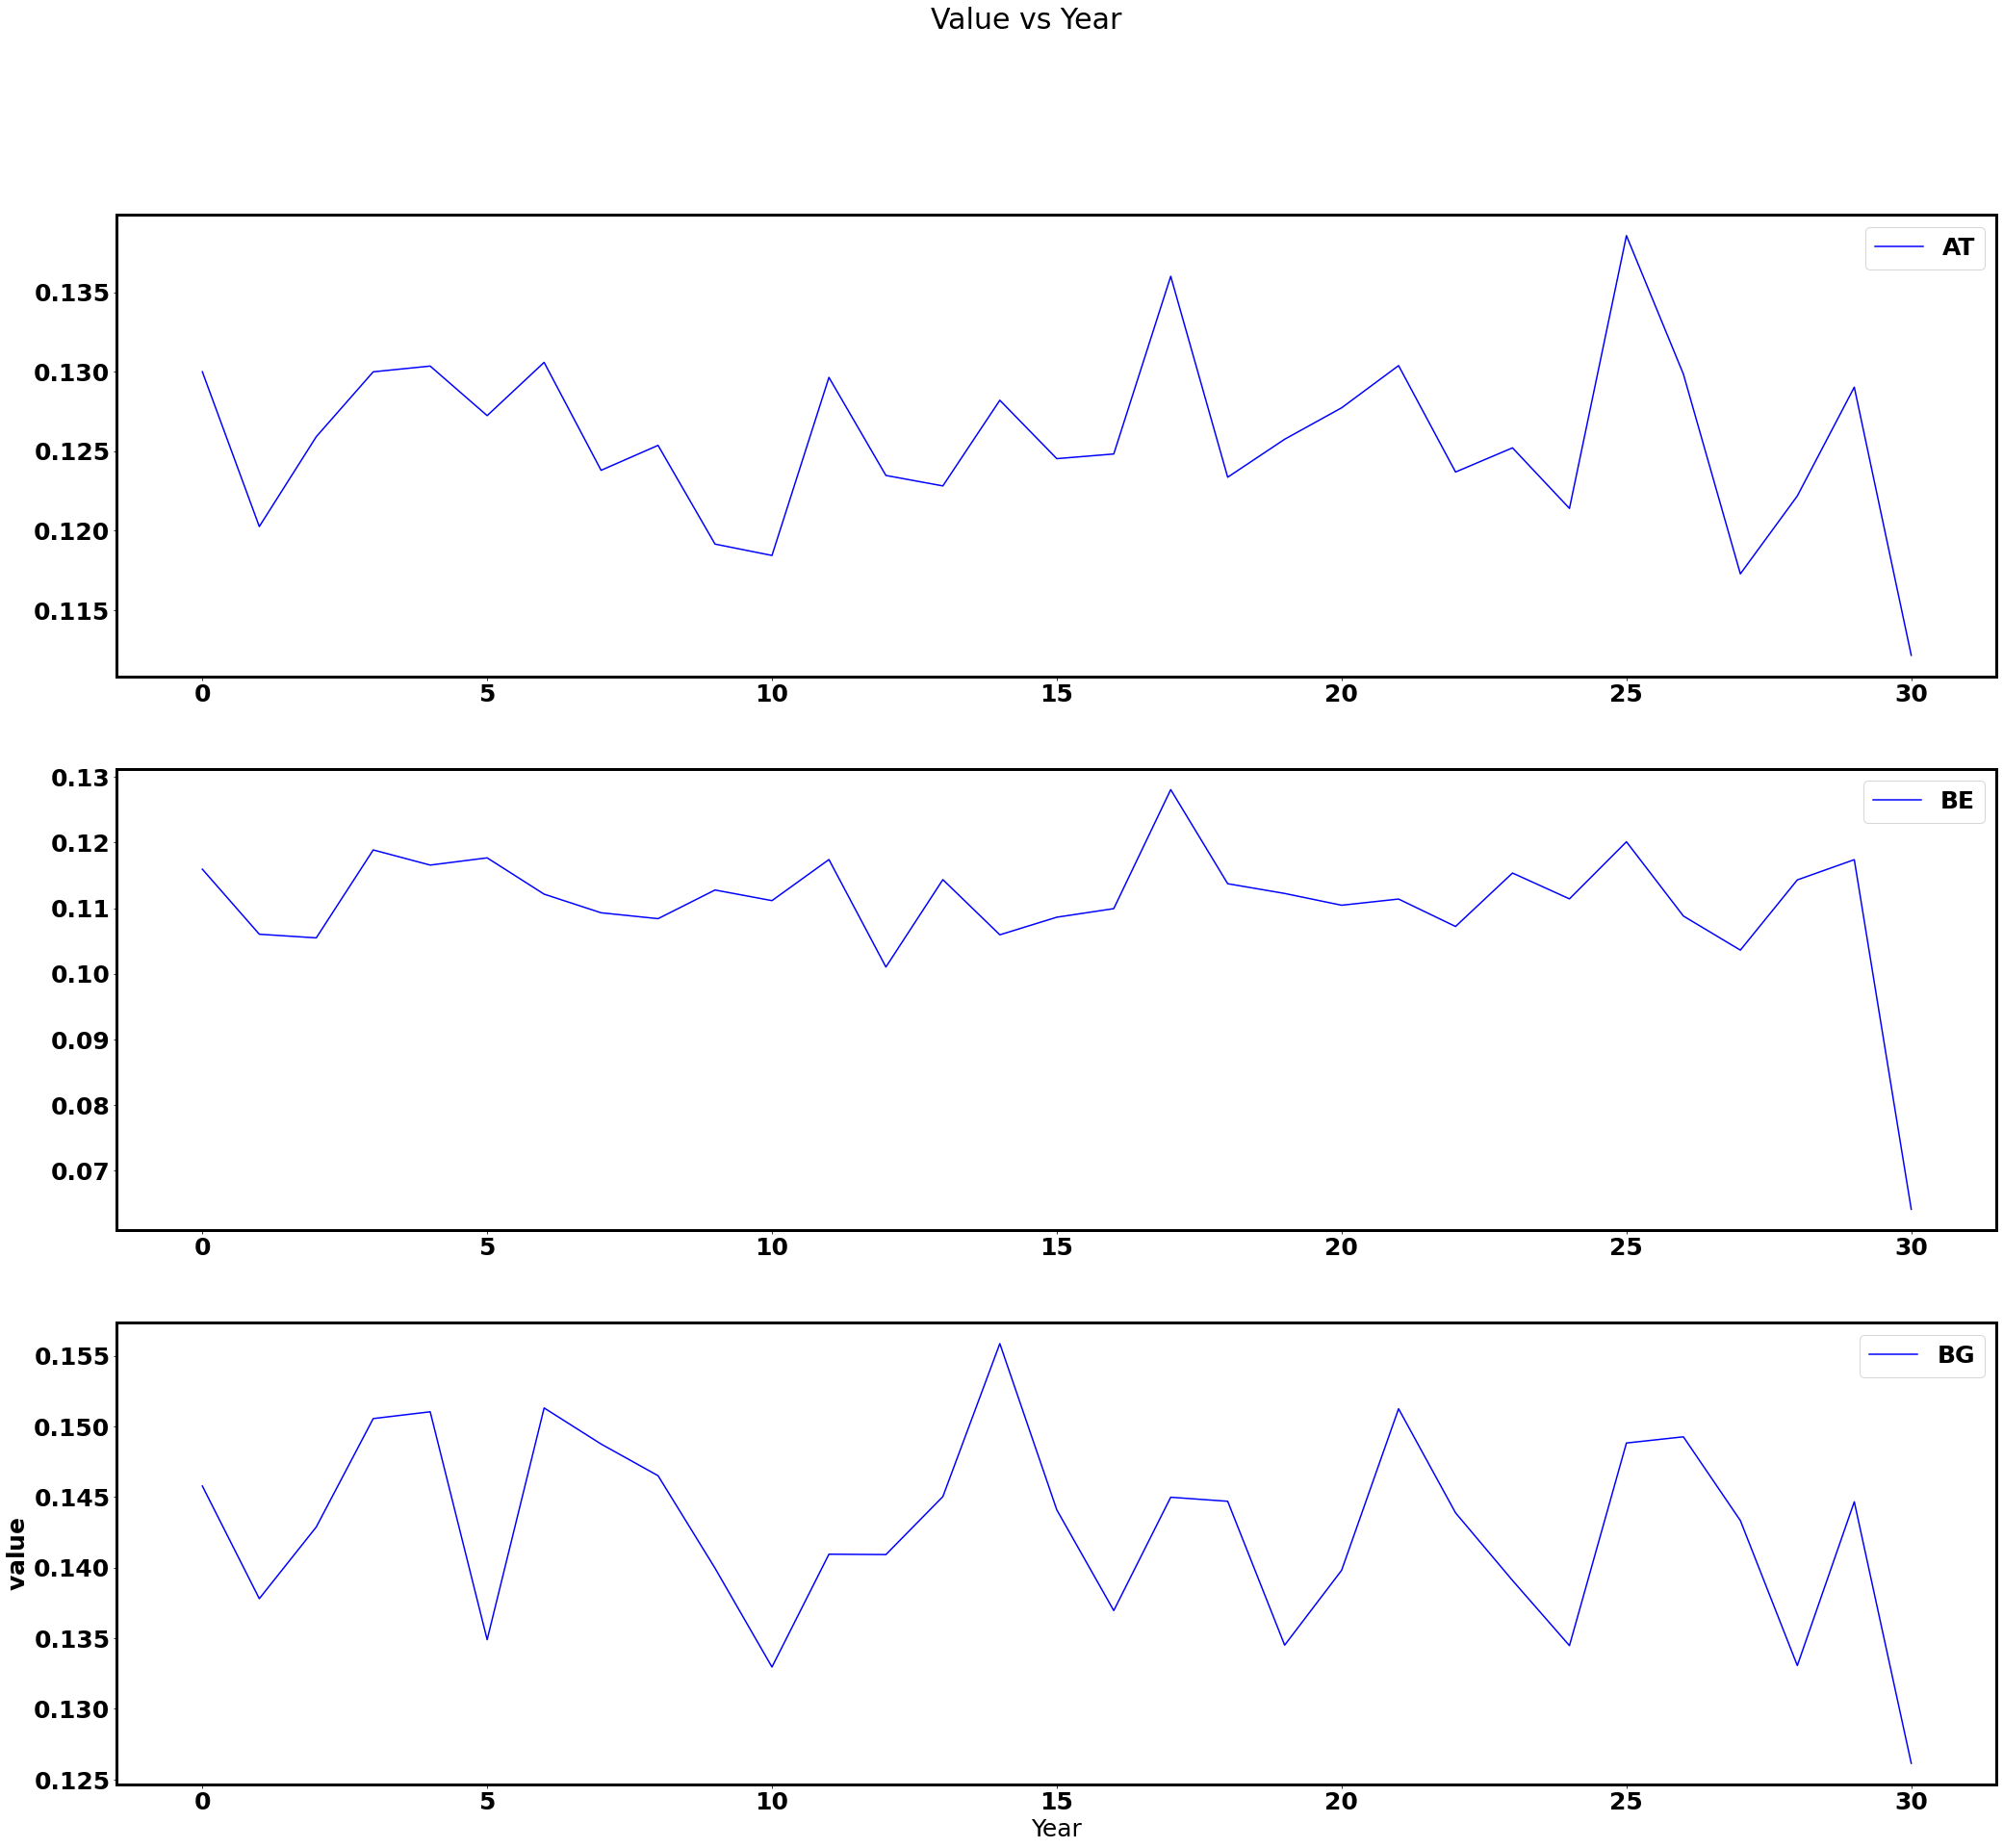

In [122]:
# PLOT VS year
df["year_delta"] = np.arange(0,df.shape[0],1)//(24*365)


from matplotlib.pylab import rc
font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


for i in range(3):
    plt.subplot(3,1,1+i)

    plt.plot(df.groupby("year_delta").mean()[names_array[i]],"b",label=names_array[i])
    plt.legend()




plt.xlabel("Year")
plt.ylabel(r"${\rm value}$")
plt.suptitle("Value vs Year")

fig = matplotlib.pyplot.gcf()

fig.set_size_inches(35,30)

save_path = plot_path + "Data_Value_VS_year" + ".png"

fig.savefig(save_path, dpi=200)










# Thus, the model must have both long and short term memory
Careful with out of memory problem

In [3]:
# LSTM baseline:
# Use one year as delta_t? Seems to big but a good start point
df = EMHIRESPV_TSh_CF_Country_19862015
names_array = list(df.keys()[:29])
delta_t = 24*180

n_epoch=10
n_cell = 50

checkpoint_path = "LSTM/EU.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

index_name = 0

# shape -1*delta_t*1
## Remember to normalize the data before put that into the LSTM

min_max_scaler = preprocessing.StandardScaler()

# min-max scaler
np_scaled = min_max_scaler.fit_transform(df[names_array])

df_scaled = pd.DataFrame(np_scaled,columns=names_array)


X = np.zeros((df_scaled.shape[0]-delta_t,delta_t,1),dtype=float)
y = df_scaled[names_array[index_name]][delta_t:]

import sys
print("Size of input X in GB: %.2f"%float(sys.getsizeof(X)/1024**3))
# Prepare the data:

for i in range(len(y)):
    if i%50000==0:
        print("Prepare data %.2f percent"%(100*i/len(y)))
    X[i,:,:] = np.atleast_2d(df_scaled[i:i+delta_t][names_array[index_name]].values).T
    
# split train test:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True)

print("Finished preparing data")  

# design network: A toy LSTM model for EU data
model = tf.keras.Sequential([
  tf.keras.layers.LSTM(n_cell,input_shape=(X_train.shape[1],X_train.shape[2])),  # must declare input shape
  tf.keras.layers.Dense(1)
])

model.compile(loss='mae', optimizer='adam')
model.summary()

# fitting+save model

callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

history = model.fit(X_train, y_train, epochs=n_epoch, batch_size=64, validation_data=(X_test, y_test),callbacks=[callback], verbose=1, shuffle=False)


## load model
#model.load_weights(checkpoint_path)








Size of input X in GB: 8.32
Prepare data 0.00 percent
Prepare data 19.33 percent
Prepare data 38.66 percent
Prepare data 57.99 percent
Prepare data 77.33 percent
Prepare data 96.66 percent
Finished preparing data
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                10400     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
2829/2829 [==============================] - ETA: 0s - loss: 0.0980
Epoch 00001: saving model to LSTM/EU.ckpt
2829/2829 [==============================] - 696s 246ms/step - loss: 0.0980 - val_loss: 0.0665
Epoch 2/10
2829/2829 [==============================] - ETA: 0s - loss: 0.0666
Epoch 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=False)
y_pre = model.predict(X_test)
"""
y_pre = model.predict(X)
fusion = np.c_[y,y_pre]
np.savetxt("LSTM_eu_results.txt",fusion)

"""




'\ny_pre = model.predict(X)\nfusion = np.c_[y,y_pre]\nnp.savetxt("LSTM_eu_results.txt",fusion)\n\n'

Done


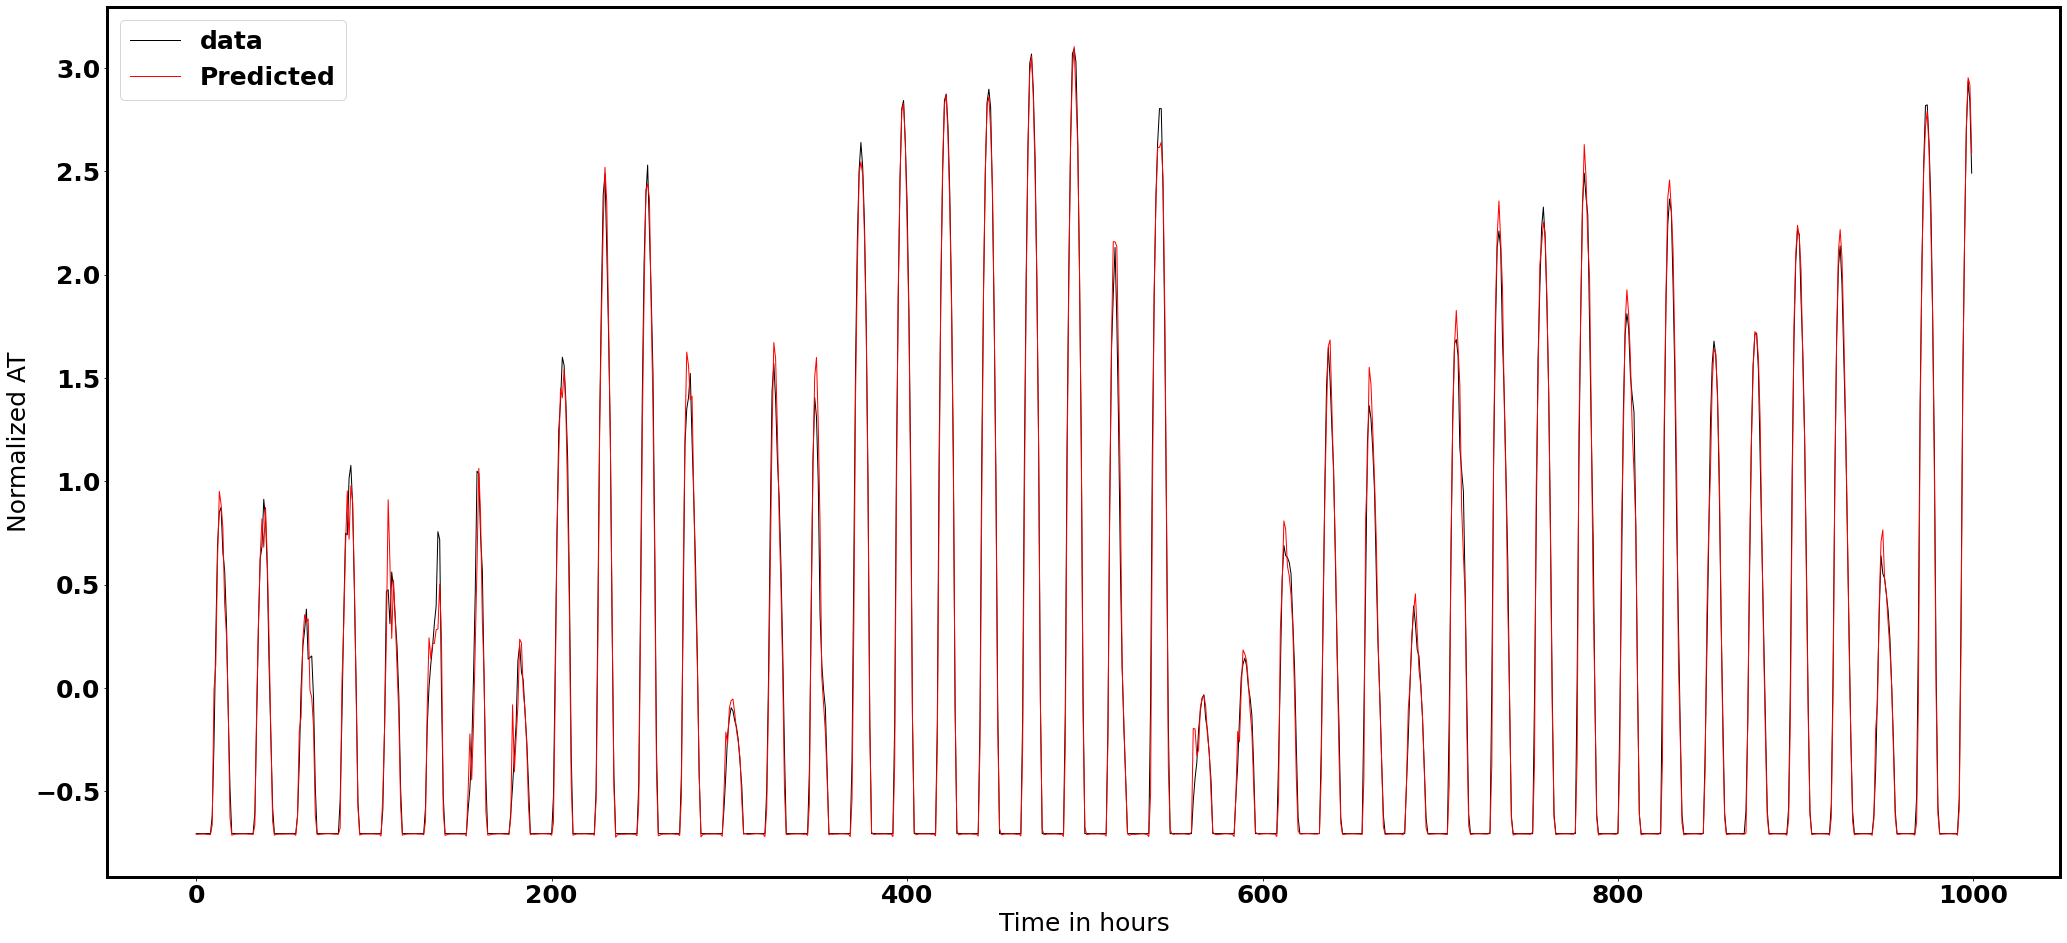

In [7]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline[:1000],y_test[:1000],"k",label="data",alpha=1,linewidth=1)
plt.plot(timeline[:1000],y_pre[:,0][:1000],"r",label="Predicted",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "EU_LSTM_results" + ".png"

fig.savefig(save_path, dpi=150)




print("Done")

Done


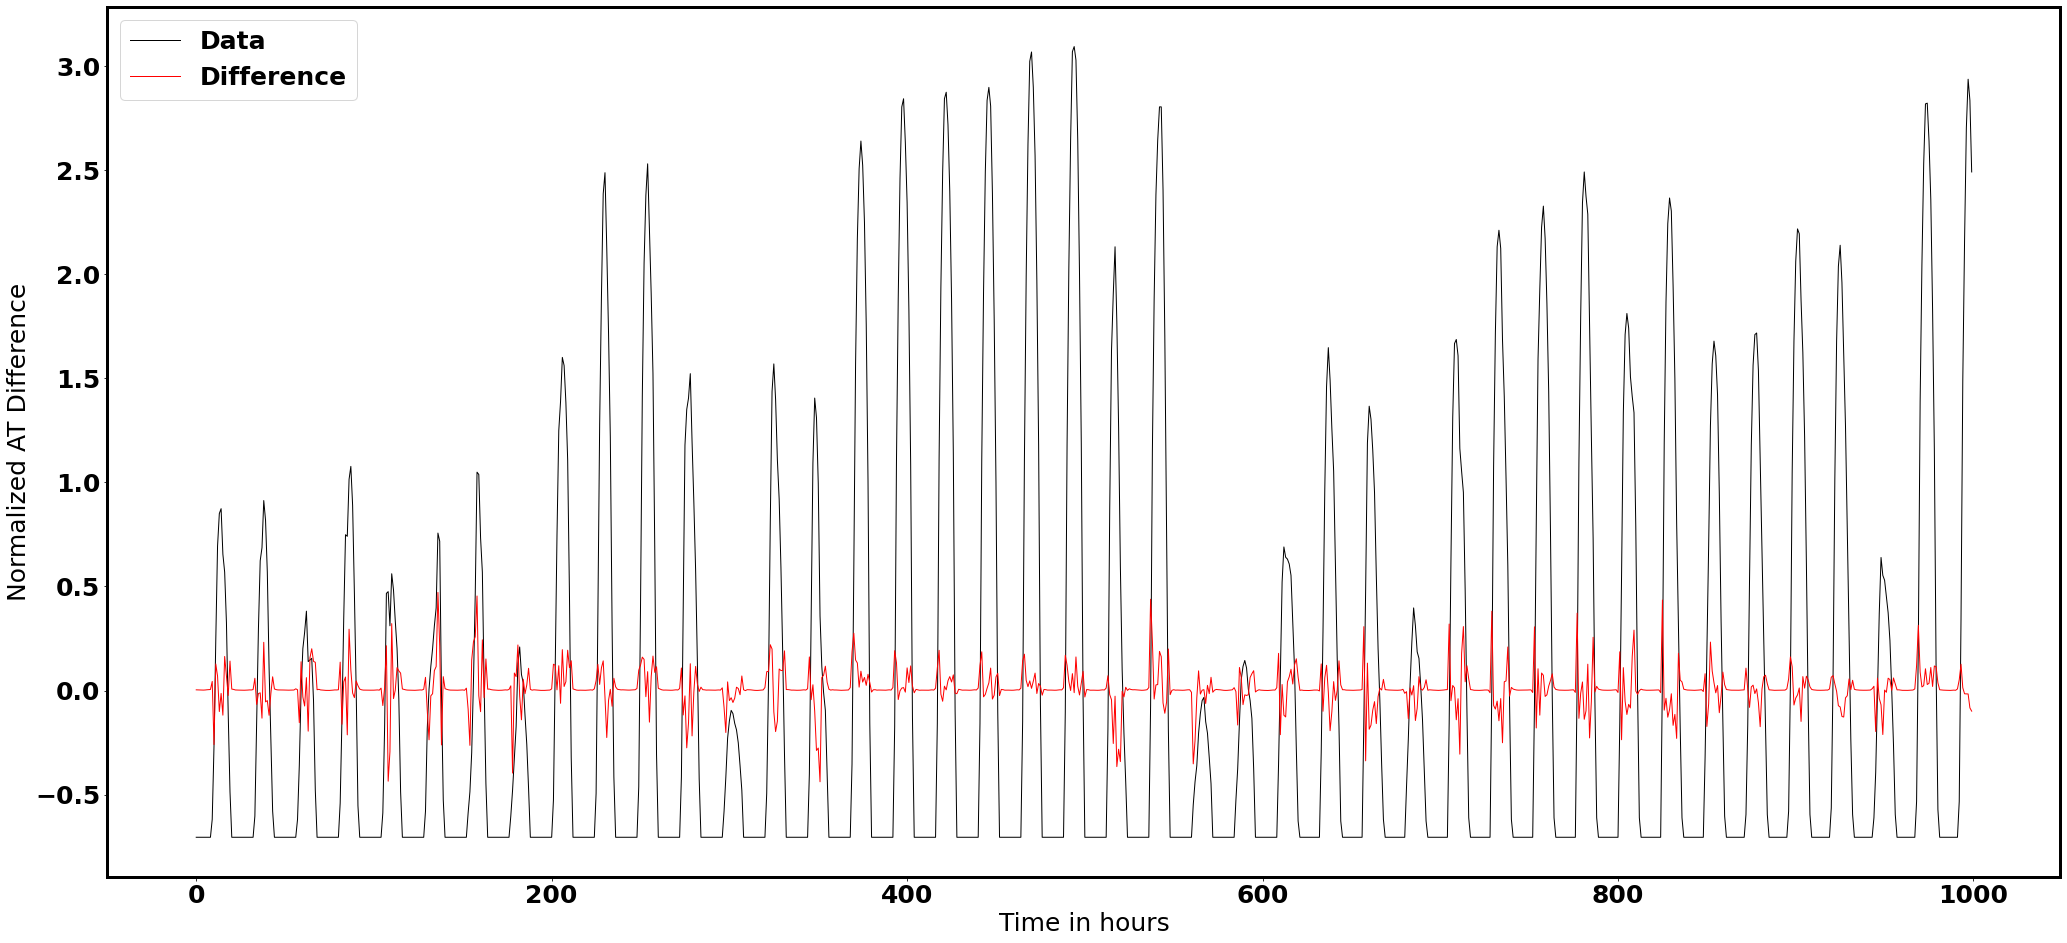

In [9]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.plot(timeline[:1000],y_test[:1000],"k",label="Data",alpha=1,linewidth=1)
plt.plot(timeline[:1000],y_test[:1000]-y_pre[:,0][:1000],"r",label="Difference",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s Difference"%names_array[index_name])

plt.legend()

fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "EU_LSTM_results_diff" + ".png"

fig.savefig(save_path, dpi=150)




print("Done")

Done


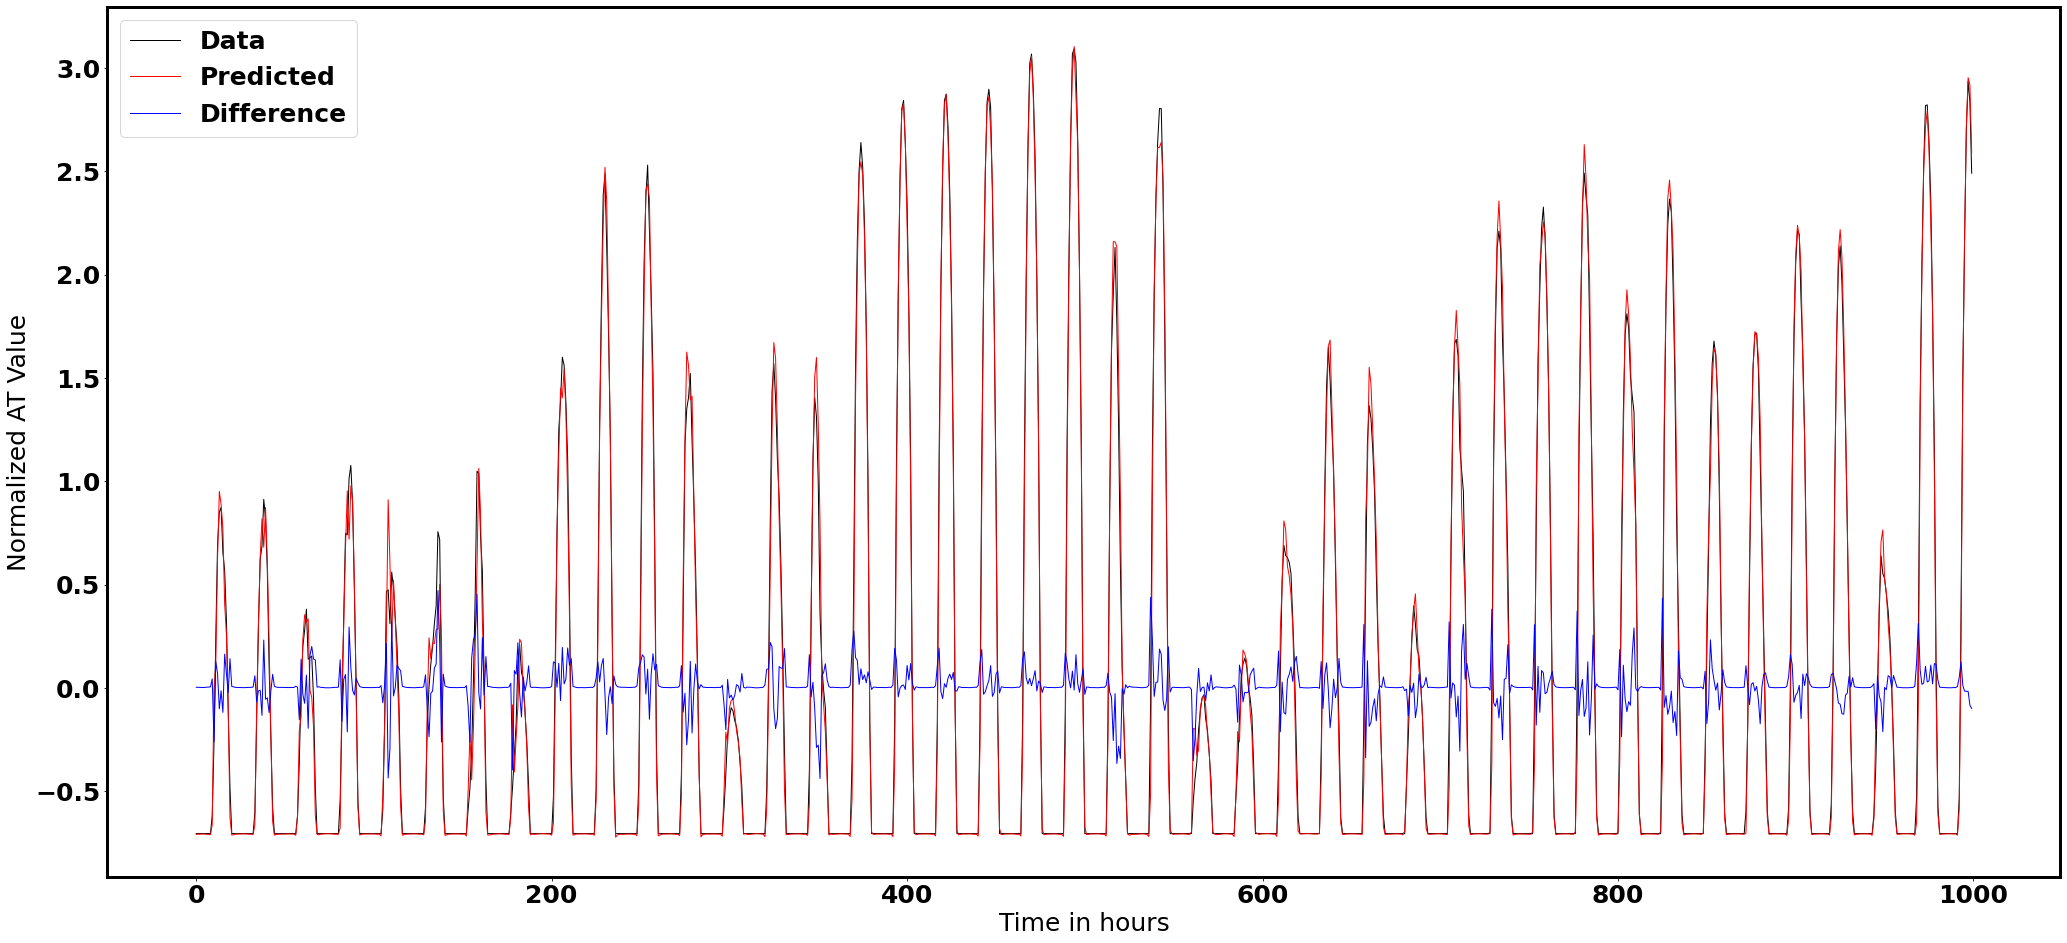

In [11]:

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

plt.subplot(1,1,1)
plt.plot(timeline[:1000],y_test[:1000],"k",label="Data",alpha=1,linewidth=1)
plt.plot(timeline[:1000],y_pre[:,0][:1000],"r",label="Predicted",alpha=1,linewidth=1)
plt.plot(timeline[:1000],y_test[:1000]-y_pre[:,0][:1000],"b",label="Difference",alpha=1,linewidth=1)
plt.xlabel("Time in hours")
plt.ylabel("Normalized %s Value"%names_array[index_name])

plt.legend()


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "EU_LSTM_results_fusion" + ".png"

fig.savefig(save_path, dpi=150)




print("Done")

Done


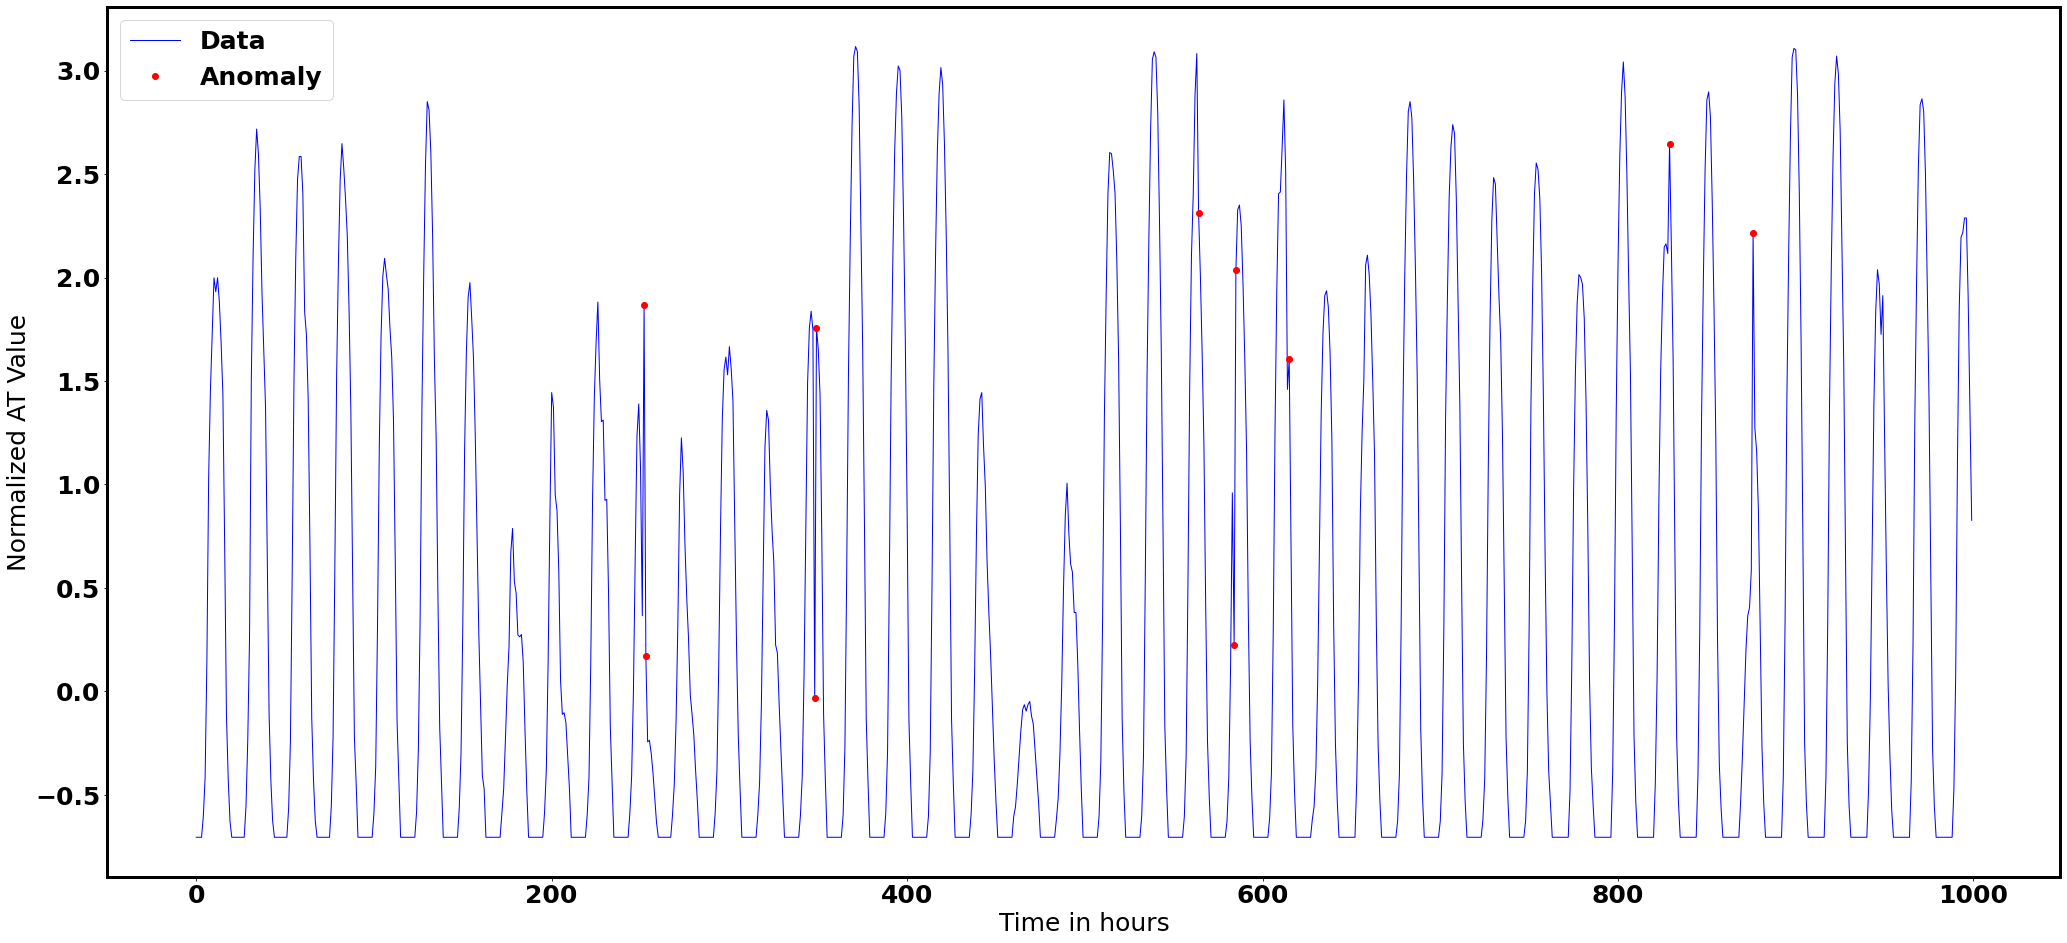

In [13]:
# predict anomaly 

font = {'family': 'normal','weight': 'bold',
        'size': 25}

matplotlib.rc('font', **font)
rc('axes', linewidth=3)


timeline = np.arange(0,len(y_test),1)

diff = y_pre[:,0][:1000]-y_test[:1000]
mask = abs(diff)>np.nanpercentile(abs(diff),99)

plt.subplot(1,1,1)
plt.plot(timeline[:1000],y_test[:1000],"b",label="Data",alpha=1,linewidth=1)
plt.plot(timeline[:1000][mask],y_test[:1000][mask],"ro",label="Anomaly",alpha=1,linewidth=1)

plt.xlabel("Time in hours")
plt.ylabel("Normalized %s Value"%names_array[index_name])

plt.legend()


fig = matplotlib.pyplot.gcf()


fig.set_size_inches(35,16)
save_path = plot_path + "EU_LSTM_anomaly" + ".png"

fig.savefig(save_path, dpi=150)




print("Done")

In [12]:

y_pre = model.predict(X)
fusion = np.c_[y,y_pre]
np.savetxt("LSTM_eu_results.txt",fusion)

